In [7]:
import augur
import time

# import everything from githubapi.py and ghtorrent.py so we can
# just copy and paste our function later
import json
import re
from dateutil.parser import parse
import pandas as pd
import github
import numpy as np
import sqlalchemy as s
import datetime
import requests
%matplotlib inline

# create an Augur application so we can test our function
augurApp = augur.Application('../augur.cfg')
github = augurApp.github()
ghtorrent = augurApp.ghtorrent()


## GitHub API Example Function

In [8]:
# We are writing this function to be run as part of the GitHub class, so 
# the "self" in this function will be an instance of an augur.GitHubAPI
def lines_deleted(self, owner, repo=None): 
    """
    Additions and deletions each week

    :param owner: The name of the project owner
    :param repo: The name of the repo
    :return: DataFrame with each row being am issue
    """
    # get the data we need from the GitHub API
    # see <project_root>/augur/githubapi.py for examples using the GraphQL API
    url = "https://api.github.com/repos/{}/{}/stats/code_frequency".format(owner, repo)
    json = requests.get(url, auth=('user', self.GITHUB_API_KEY)).json()
    # get our data into a dataframe
    df = pd.DataFrame(json, columns=['date', 'additions', 'deletions'])
    # all timeseries metrics need a 'date' column
    df['date'] = pd.to_datetime(df['date'], unit='s', infer_datetime_format=True)
    # normalize our data and create useful aggregates
    df['deletions'] = df['deletions'] * -1
    df.drop(columns=['additions'])
    # return the dataframe
    return df

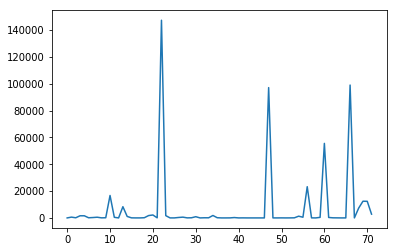

In [9]:
# add our new function to the class
augur.GitHubAPI.lines_deleted = lines_deleted

# sleep is in there to give the GitHub API time to make its first response. 
time.sleep(2)

# test our function on the initialized instance
ld = github.lines_deleted('osshealth', 'augur')
ld['deletions'].plot()


## GHTorrent Example Function

In [10]:
# all Augur functions that provide data should accept at least these arguments
#
# we are writing this function to be run as part of the GHTorrent class, so 
# the "self" in this function will be an instance of an augur.GHTorrent
def issues_closed_by_month(self, owner, repo=None):
        # get the repoid we will need in our query
        repoid = self.repoid(owner, repo)
        # write our query
        sql = s.sql.text("""
        SELECT DATE_FORMAT(issue_events.created_at, '%Y-%m') as "date", COUNT(*) as issues_closed
            FROM issue_events, issues
            WHERE issue_events.issue_id = issues.id
            AND issue_events.action = "closed"
            AND issues.repo_id = :repoid
            GROUP BY YEAR(issue_events.created_at), MONTH(issue_events.created_at)
        """)
        # return a dataframe of the results of the query
        return pd.read_sql(sql, self.db, params={"repoid": str(repoid)})


# add our new function to the class
augur.GHTorrent.issues_closed_by_month = issues_closed_by_month

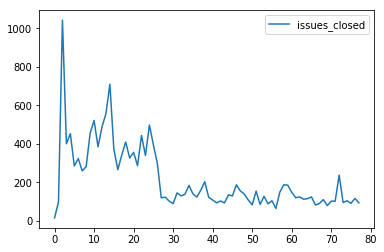

In [11]:
# test our function on the initialized instance
rails_closed_per_month = ghtorrent.issues_closed_by_month('rails', 'rails')
rails_closed_per_month.plot()

In [12]:
def __single_table_count_by_date(self, table, repo_col='project_id', user_col='author_id', group_by="week"):
    """
    Generates query string to count occurances of rows per date for a given table.
    External input must never be sent to this function, it is for internal use only.

    :param table: The table in GHTorrent to generate the string for
    :param repo_col: The column in that table with the project ids
    :param user_col: The column in that table with the user ids
    :param group_by: Default week; Options raw, day, week, month, year; Selects period of time to be grouped by
    :return: Query string
    """
    if group_by == "raw":
        return """
            SELECT date(created_at) AS "date", {2} AS "user_id"
            FROM {0}
            WHERE {1} = :repoid
            """.format(table, repo_col, user_col)

    if group_by == "day":
        return """
            SELECT date(created_at) AS "date", COUNT(*) AS "{0}"
            FROM {0} 
            WHERE {1} = :repoid
            GROUP BY DATE(created_at)""".format(table, repo_col)

    if group_by == "week":
        return """
            SELECT date(created_at) AS "date", COUNT(*) AS "{0}"
            FROM {0}
            WHERE {1} = :repoid
            GROUP BY YEARWEEK(created_at)""".format(table, repo_col)

    if group_by == "month":
        return """
            SELECT date(created_at) AS "date", COUNT(*) AS "{0}"
            FROM {0}
            WHERE {1} = :repoid
            GROUP BY MONTH(created_at), YEAR(created_at)""".format(table, repo_col)

    if group_by == "year":
        return """
            SELECT date(created_at) AS "date", COUNT(*) AS "{0}"
            FROM {0}
            WHERE {1} = :repoid
            GROUP BY YEAR(created_at)""".format(table, repo_col)

# Example of using commits to find those over 100
def commits100(self, owner, repo=None, group_by="week"):
    """
    Timeseries of all the commits on a repo

    :param owner: The name of the project owner or the id of the project in the projects table of the project in the projects table. Use repoid() to get this.
    :param repo: The name of the repo. Unneeded if repository id was passed as owner.
    :return: DataFrame with commits/day
    """
    repoid = self.repoid(owner, repo)
    commitsSQL = s.sql.text(self.__single_table_count_by_date('commits', group_by=group_by))
    temp = pd.read_sql(commitsSQL, self.db, params={"repoid": str(repoid)})
    tem = temp['commits'] > 100
    return temp[tem].reset_index(drop=True)

# add our new function to the class
augur.GHTorrent.commits100 = commits100

# add our new function to the class
augur.GHTorrent.__single_table_count_by_date = __single_table_count_by_date

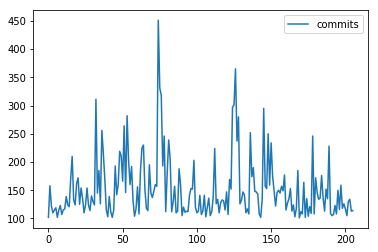

In [13]:
rails_commits100 = ghtorrent.commits100('rails','rails')
rails_commits100.plot()

In [14]:
#Determines the amount of fake users were made for a particular week
def fakes(self, owner, repo=None):
    repoid = self.repoid(owner, repo)
    contributorsSQL = s.sql.text("""
        SELECT date(created_at) AS "date", COUNT(*) AS fakes
        FROM users
        WHERE fake = true
        GROUP BY YEARWEEK(date)
    """)	
    return pd.read_sql(contributorsSQL, self.db, params={"repoid": str(repoid)})

# add our new function to the class
augur.GHTorrent.fakes = fakes

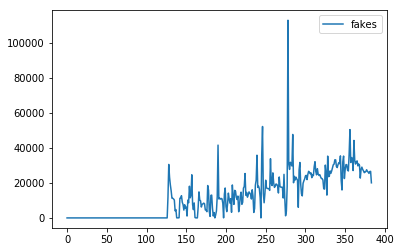

In [15]:
rails_fakes = ghtorrent.fakes('rails','rails')
rails_fakes.plot()